In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV, cross_validate,cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
warnings.filterwarnings('ignore')

In [315]:
import optuna
from optuna.samplers import TPESampler

In [ ]:
import os
os.chdir(r'C:\Users\ADMIN\Desktop\EMLforSAI')  #Replace with the file path of EMLforSAI in your system.

In [ ]:
df=pd.read_csv(r'./Dataset/ML_data.csv')
df

,No,Grade,A1,A2,A3,A4,B1,B2,B3,B4,B5,C1,C2,C3,C4,y
0,1,freshman,5,5,5,5,5,5,5,5,5,1,1,1,1,5
1,2,freshman,3,3,4,3,4,4,4,4,3,2,3,3,4,4
2,3,freshman,2,2,2,2,2,2,2,5,2,4,4,4,4,4
3,4,freshman,5,5,5,5,5,5,5,5,5,2,2,2,2,5
4,5,freshman,5,5,5,5,5,5,5,5,5,2,1,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682,683,senior,4,3,3,4,3,3,4,4,2,4,4,4,4,3
683,684,senior,4,4,4,4,5,5,5,5,3,2,3,5,4,4
684,685,senior,5,5,5,5,5,5,5,5,5,5,5,5,5,5
685,686,senior,4,4,4,4,4,4,4,4,4,2,3,2,2,4


In [328]:
df = df.dropna(subset=['y'])
feature_columns = ['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4', 'B5', 
                   'C1', 'C2', 'C3', 'C4']


In [329]:
def categorize_y(value):
    if pd.isna(value):
        return np.nan
    elif value <= 3:
        return 2
    elif value == 4:
        return 1
    elif value == 5:
        return 0
    else:
        return np.nan

df['y_category'] = df['y'].apply(categorize_y)

In [303]:
df['y_category'] = df['y'].apply(categorize_y)
df = df.dropna(subset=['y_category'])

In [360]:
X = df[feature_columns]
y = df['y_category']

print("=== 数据概况 ===")
print(f"总样本数: {len(X)}")
print(f"特征数量: {len(feature_columns)}")
print(f"特征: {feature_columns}")
print(f"\n类别分布:")
print(y.value_counts().sort_index())
print(f"比例: {y.value_counts(normalize=True).sort_index()}")

=== 数据概况 ===
总样本数: 687
特征数量: 13
特征: ['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4']

类别分布:
0    148
1    289
2    250
Name: y_category, dtype: int64
比例: 0    0.215429
1    0.420670
2    0.363901
Name: y_category, dtype: float64


In [ ]:
# 5. 五折交叉验证训练和评估模型
print("\n=== 五折交叉验证 ===")
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# 定义XGBoost模型
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    random_state=42
)

# 使用交叉验证获取预测结果
print("进行五折交叉验证预测...")
y_pred_cv = cross_val_predict(xgb_model, X, y, cv=kfold)
y_pred_proba_cv = cross_val_predict(xgb_model, X, y, cv=kfold, method='predict_proba')

# 计算交叉验证的准确率
cv_accuracy = accuracy_score(y, y_pred_cv)
print(f"五折交叉验证准确率: {cv_accuracy:.4f}")

=== 数据概况 ===
总样本数: 687
特征数量: 13
特征: ['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4']

类别分布:
0    148
1    289
2    250
Name: y_category, dtype: int64
比例: 0    0.215429
1    0.420670
2    0.363901
Name: y_category, dtype: float64

=== 五折交叉验证 ===
进行五折交叉验证预测...
五折交叉验证准确率: 0.7991


In [82]:
# 4. 定义Optuna目标函数
def objective(trial):
    """
    Optuna目标函数，返回交叉验证的准确率
    """
    # 定义参数搜索空间
    params = {
        'objective': 'multi:softprob',
        'num_class': 3,
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': 0,
        
        # 树结构参数
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        
        # 学习过程参数
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        
        # 采样参数
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        
        # 正则化参数
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10, log=True),
        
        # 分裂控制
        'gamma': trial.suggest_float('gamma', 0.001, 5, log=True),
        
        # 高级参数
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 10),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
    }
    
    # 如果是lossguide生长策略，设置max_leaves
    if params['grow_policy'] == 'lossguide':
        params['max_leaves'] = trial.suggest_int('max_leaves', 10, 100)
    
    # 创建模型
    model = xgb.XGBClassifier(**params)
    
    # 使用交叉验证计算分数
    scores = cross_val_score(model, X, y, cv=kfold, scoring='accuracy', n_jobs=-1)
    
    # 返回平均准确率
    return np.mean(scores)

In [83]:
# 5. 创建Optuna研究并运行优化
print("\n开始Optuna贝叶斯优化...")
study = optuna.create_study(
    direction='maximize',  # 最大化准确率
    sampler=TPESampler(seed=42),  # 使用TPE采样器
    pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=5, interval_steps=1)
)

# 运行优化
n_trials = 100  # 试验次数
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

[I 2025-12-19 22:47:25,713] A new study created in memory with name: no-name-8b5e3397-033d-446d-b23a-bb82dabb96c2



开始Optuna贝叶斯优化...


Best trial: 0. Best value: 0.812345:   1%|          | 1/100 [00:00<01:30,  1.10it/s]

[I 2025-12-19 22:47:26,626] Trial 0 finished with value: 0.8123452872104094 and parameters: {'max_depth': 5, 'min_child_weight': 10, 'learning_rate': 0.06504856968981275, 'n_estimators': 319, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'colsample_bylevel': 0.5290418060840998, 'reg_alpha': 2.9154431891537547, 'reg_lambda': 0.2537815508265665, 'gamma': 0.4160439645256604, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.8123452872104094.


Best trial: 0. Best value: 0.812345:   2%|▏         | 2/100 [00:01<01:09,  1.41it/s]

[I 2025-12-19 22:47:27,191] Trial 1 finished with value: 0.8108536972389718 and parameters: {'max_depth': 4, 'min_child_weight': 2, 'learning_rate': 0.002846526357761094, 'n_estimators': 187, 'subsample': 0.762378215816119, 'colsample_bytree': 0.7159725093210578, 'colsample_bylevel': 0.645614570099021, 'reg_alpha': 0.2801635158716261, 'reg_lambda': 0.003613894271216527, 'gamma': 0.012040216379191714, 'max_delta_step': 4, 'grow_policy': 'lossguide', 'max_leaves': 28}. Best is trial 0 with value: 0.8123452872104094.


Best trial: 0. Best value: 0.812345:   3%|▎         | 3/100 [00:02<01:04,  1.51it/s]

[I 2025-12-19 22:47:27,794] Trial 2 finished with value: 0.8035755844705385 and parameters: {'max_depth': 7, 'min_child_weight': 6, 'learning_rate': 0.0013033567475147442, 'n_estimators': 324, 'subsample': 0.5852620618436457, 'colsample_bytree': 0.5325257964926398, 'colsample_bylevel': 0.9744427686266666, 'reg_alpha': 7.2866537374910445, 'reg_lambda': 1.7123375973163988, 'gamma': 0.013389279116695478, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.8123452872104094.


Best trial: 0. Best value: 0.812345:   4%|▍         | 4/100 [00:02<01:05,  1.47it/s]

[I 2025-12-19 22:47:28,508] Trial 3 finished with value: 0.810843118586692 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'learning_rate': 0.0012167028814593455, 'n_estimators': 460, 'subsample': 0.6293899908000085, 'colsample_bytree': 0.831261142176991, 'colsample_bylevel': 0.6558555380447055, 'reg_alpha': 0.12030178871154672, 'reg_lambda': 0.1537592023548176, 'gamma': 0.0048280425192712886, 'max_delta_step': 10, 'grow_policy': 'lossguide', 'max_leaves': 91}. Best is trial 0 with value: 0.8123452872104094.


Best trial: 0. Best value: 0.812345:   5%|▌         | 5/100 [00:03<01:00,  1.56it/s]

[I 2025-12-19 22:47:29,078] Trial 4 finished with value: 0.8065270284565746 and parameters: {'max_depth': 7, 'min_child_weight': 10, 'learning_rate': 0.0016565580440884786, 'n_estimators': 138, 'subsample': 0.522613644455269, 'colsample_bytree': 0.6626651653816322, 'colsample_bylevel': 0.6943386448447411, 'reg_alpha': 0.01217295809836997, 'reg_lambda': 2.0651425578959257, 'gamma': 0.020874681332882276, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.8123452872104094.


Best trial: 7. Best value: 0.813763:   8%|▊         | 8/100 [00:04<00:34,  2.68it/s]

[I 2025-12-19 22:47:29,762] Trial 5 finished with value: 0.7991219718607849 and parameters: {'max_depth': 9, 'min_child_weight': 1, 'learning_rate': 0.27838036931305016, 'n_estimators': 398, 'subsample': 0.5993578407670862, 'colsample_bytree': 0.5027610585618012, 'colsample_bylevel': 0.9077307142274171, 'reg_alpha': 0.6720930050156113, 'reg_lambda': 0.8241925264876453, 'gamma': 0.7126985539523761, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.8123452872104094.
[I 2025-12-19 22:47:29,809] Trial 6 finished with value: 0.8123135512535702 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'learning_rate': 0.006601984958164864, 'n_estimators': 78, 'subsample': 0.6554911608578311, 'colsample_bytree': 0.6625916610133735, 'colsample_bylevel': 0.864803089169032, 'reg_alpha': 0.35500125258511606, 'reg_lambda': 3.53875886477924, 'gamma': 0.05580959150991868, 'max_delta_step': 1, 'grow_policy': 'lossguide', 'max_leaves': 61}. Best is trial 0 with value: 0.812

Best trial: 7. Best value: 0.813763:  10%|█         | 10/100 [00:04<00:23,  3.80it/s]

[I 2025-12-19 22:47:29,994] Trial 8 finished with value: 0.8064423992383372 and parameters: {'max_depth': 4, 'min_child_weight': 1, 'learning_rate': 0.005220949381122231, 'n_estimators': 122, 'subsample': 0.9648488261712865, 'colsample_bytree': 0.9040601897822085, 'colsample_bylevel': 0.8167018782552118, 'reg_alpha': 3.06085221067225, 'reg_lambda': 1.6394127471631603, 'gamma': 0.004899108428855473, 'max_delta_step': 9, 'grow_policy': 'lossguide', 'max_leaves': 91}. Best is trial 7 with value: 0.8137628266158892.
[I 2025-12-19 22:47:30,141] Trial 9 finished with value: 0.8093726859198138 and parameters: {'max_depth': 5, 'min_child_weight': 2, 'learning_rate': 0.0036696364068833334, 'n_estimators': 242, 'subsample': 0.9090073829612466, 'colsample_bytree': 0.9303652916281717, 'colsample_bylevel': 0.5034760652655954, 'reg_alpha': 0.11040511903162252, 'reg_lambda': 0.0467351899956275, 'gamma': 0.00663086412368092, 'max_delta_step': 1, 'grow_policy': 'lossguide', 'max_leaves': 39}. Best is t

Best trial: 11. Best value: 0.813795:  12%|█▏        | 12/100 [00:04<00:19,  4.55it/s]

[I 2025-12-19 22:47:30,327] Trial 10 finished with value: 0.8094044218766528 and parameters: {'max_depth': 10, 'min_child_weight': 4, 'learning_rate': 0.01976173104851797, 'n_estimators': 257, 'subsample': 0.7512656088373982, 'colsample_bytree': 0.7876040334076364, 'colsample_bylevel': 0.584393186743932, 'reg_alpha': 0.001824181869756455, 'reg_lambda': 0.008963062412681348, 'gamma': 4.68510936324048, 'max_delta_step': 7, 'grow_policy': 'lossguide', 'max_leaves': 69}. Best is trial 7 with value: 0.8137628266158892.
[I 2025-12-19 22:47:30,468] Trial 11 finished with value: 0.8137945625727283 and parameters: {'max_depth': 6, 'min_child_weight': 9, 'learning_rate': 0.046781596578712344, 'n_estimators': 353, 'subsample': 0.5022269643958299, 'colsample_bytree': 0.5797756936951975, 'colsample_bylevel': 0.5019080850767946, 'reg_alpha': 1.645721864179539, 'reg_lambda': 0.044067722021421486, 'gamma': 0.3210241236506723, 'max_delta_step': 7, 'grow_policy': 'depthwise'}. Best is trial 11 with valu

Best trial: 12. Best value: 0.816672:  13%|█▎        | 13/100 [00:04<00:18,  4.73it/s]

[I 2025-12-19 22:47:30,655] Trial 12 finished with value: 0.8166719559928065 and parameters: {'max_depth': 8, 'min_child_weight': 8, 'learning_rate': 0.03955799307227323, 'n_estimators': 412, 'subsample': 0.5014749885200818, 'colsample_bytree': 0.6082802910500238, 'colsample_bylevel': 0.5822448453612438, 'reg_alpha': 0.016832312970958996, 'reg_lambda': 0.022701605786719568, 'gamma': 0.32220324675464596, 'max_delta_step': 7, 'grow_policy': 'depthwise'}. Best is trial 12 with value: 0.8166719559928065.


Best trial: 12. Best value: 0.816672:  14%|█▍        | 14/100 [00:05<00:18,  4.63it/s]

[I 2025-12-19 22:47:30,883] Trial 13 finished with value: 0.8064635565428965 and parameters: {'max_depth': 6, 'min_child_weight': 8, 'learning_rate': 0.06735333293331695, 'n_estimators': 500, 'subsample': 0.8256139655211496, 'colsample_bytree': 0.6245388140608049, 'colsample_bylevel': 0.5896917783588302, 'reg_alpha': 0.019204398733510958, 'reg_lambda': 0.0016187127376097864, 'gamma': 0.4002582590504131, 'max_delta_step': 6, 'grow_policy': 'depthwise'}. Best is trial 12 with value: 0.8166719559928065.


Best trial: 12. Best value: 0.816672:  15%|█▌        | 15/100 [00:05<00:17,  4.73it/s]

[I 2025-12-19 22:47:31,082] Trial 14 finished with value: 0.8093832645720935 and parameters: {'max_depth': 8, 'min_child_weight': 8, 'learning_rate': 0.073326126169036, 'n_estimators': 393, 'subsample': 0.660529872658794, 'colsample_bytree': 0.608814028112534, 'colsample_bylevel': 0.7223116654367024, 'reg_alpha': 0.017541558521074932, 'reg_lambda': 0.03731255734361085, 'gamma': 0.0013075362536736305, 'max_delta_step': 7, 'grow_policy': 'depthwise'}. Best is trial 12 with value: 0.8166719559928065.


Best trial: 12. Best value: 0.816672:  17%|█▋        | 17/100 [00:05<00:16,  5.03it/s]

[I 2025-12-19 22:47:31,270] Trial 15 finished with value: 0.8137945625727283 and parameters: {'max_depth': 6, 'min_child_weight': 9, 'learning_rate': 0.03283989950477631, 'n_estimators': 398, 'subsample': 0.5088874313785248, 'colsample_bytree': 0.7266480756678182, 'colsample_bylevel': 0.5915631846039581, 'reg_alpha': 0.0019711216733250304, 'reg_lambda': 0.007787624170325386, 'gamma': 1.5909941232781208, 'max_delta_step': 5, 'grow_policy': 'depthwise'}. Best is trial 12 with value: 0.8166719559928065.
[I 2025-12-19 22:47:31,455] Trial 16 finished with value: 0.80352269120914 and parameters: {'max_depth': 8, 'min_child_weight': 8, 'learning_rate': 0.17299326151290215, 'n_estimators': 346, 'subsample': 0.6890374935566341, 'colsample_bytree': 0.6703610765428334, 'colsample_bylevel': 0.7657657885812352, 'reg_alpha': 0.00819341290717403, 'reg_lambda': 0.4569579673966107, 'gamma': 0.14642543447919715, 'max_delta_step': 8, 'grow_policy': 'depthwise'}. Best is trial 12 with value: 0.81667195599

Best trial: 17. Best value: 0.816693:  18%|█▊        | 18/100 [00:05<00:17,  4.65it/s]

[I 2025-12-19 22:47:31,709] Trial 17 finished with value: 0.8166931132973658 and parameters: {'max_depth': 8, 'min_child_weight': 7, 'learning_rate': 0.008542066871170016, 'n_estimators': 445, 'subsample': 0.5533168937309203, 'colsample_bytree': 0.7973736500379814, 'colsample_bylevel': 0.568103463890097, 'reg_alpha': 0.04813250181503742, 'reg_lambda': 0.07907196354102643, 'gamma': 0.17356789994731592, 'max_delta_step': 6, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.8166931132973658.


Best trial: 17. Best value: 0.816693:  19%|█▉        | 19/100 [00:06<00:19,  4.24it/s]

[I 2025-12-19 22:47:31,995] Trial 18 finished with value: 0.8079445678620543 and parameters: {'max_depth': 8, 'min_child_weight': 6, 'learning_rate': 0.009337849056027485, 'n_estimators': 443, 'subsample': 0.7024178684917459, 'colsample_bytree': 0.8563986540165556, 'colsample_bylevel': 0.6319427367666653, 'reg_alpha': 0.03445349859964112, 'reg_lambda': 0.10443765321794138, 'gamma': 1.5349349235893976, 'max_delta_step': 5, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.8166931132973658.


Best trial: 17. Best value: 0.816693:  20%|██        | 20/100 [00:06<00:20,  3.90it/s]

[I 2025-12-19 22:47:32,299] Trial 19 finished with value: 0.8152438379350471 and parameters: {'max_depth': 10, 'min_child_weight': 7, 'learning_rate': 0.010804263909871053, 'n_estimators': 495, 'subsample': 0.5643715582493518, 'colsample_bytree': 0.7917212132935939, 'colsample_bylevel': 0.7861112523458897, 'reg_alpha': 0.04045425586745325, 'reg_lambda': 0.0013030133773607173, 'gamma': 0.12018521139182788, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.8166931132973658.


Best trial: 17. Best value: 0.816693:  21%|██        | 21/100 [00:06<00:21,  3.67it/s]

[I 2025-12-19 22:47:32,611] Trial 20 finished with value: 0.8078916746006559 and parameters: {'max_depth': 7, 'min_child_weight': 4, 'learning_rate': 0.013970555178566659, 'n_estimators': 433, 'subsample': 0.8209911893586399, 'colsample_bytree': 0.9689956838245026, 'colsample_bylevel': 0.560111447323643, 'reg_alpha': 0.004564901415973858, 'reg_lambda': 0.014316710230961595, 'gamma': 0.040395372513535505, 'max_delta_step': 6, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.8166931132973658.


Best trial: 17. Best value: 0.816693:  22%|██▏       | 22/100 [00:07<00:21,  3.56it/s]

[I 2025-12-19 22:47:32,912] Trial 21 finished with value: 0.8152438379350471 and parameters: {'max_depth': 10, 'min_child_weight': 7, 'learning_rate': 0.01133133625039195, 'n_estimators': 492, 'subsample': 0.5617104625598868, 'colsample_bytree': 0.7805271306608181, 'colsample_bylevel': 0.7743116802808053, 'reg_alpha': 0.0694287264074433, 'reg_lambda': 0.0011365544133512466, 'gamma': 0.13823316145162218, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.8166931132973658.


Best trial: 17. Best value: 0.816693:  23%|██▎       | 23/100 [00:07<00:21,  3.65it/s]

[I 2025-12-19 22:47:33,168] Trial 22 finished with value: 0.8108642758912514 and parameters: {'max_depth': 10, 'min_child_weight': 7, 'learning_rate': 0.03314659334163123, 'n_estimators': 460, 'subsample': 0.5677243204969685, 'colsample_bytree': 0.8228731733671333, 'colsample_bylevel': 0.8106739399789122, 'reg_alpha': 0.04609335513323964, 'reg_lambda': 7.864923248113774, 'gamma': 0.20346839859088106, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.8166931132973658.


Best trial: 17. Best value: 0.816693:  24%|██▍       | 24/100 [00:07<00:20,  3.75it/s]

[I 2025-12-19 22:47:33,420] Trial 23 finished with value: 0.8123347085581297 and parameters: {'max_depth': 9, 'min_child_weight': 9, 'learning_rate': 0.007044814381148065, 'n_estimators': 423, 'subsample': 0.5462862819170607, 'colsample_bytree': 0.7726742915634666, 'colsample_bylevel': 0.7007317050986573, 'reg_alpha': 0.005974094428380218, 'reg_lambda': 0.003412833296438356, 'gamma': 0.9190374907903858, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.8166931132973658.


Best trial: 17. Best value: 0.816693:  25%|██▌       | 25/100 [00:07<00:20,  3.67it/s]

[I 2025-12-19 22:47:33,704] Trial 24 finished with value: 0.807923410557495 and parameters: {'max_depth': 8, 'min_child_weight': 7, 'learning_rate': 0.027667998807760115, 'n_estimators': 480, 'subsample': 0.6153413379711878, 'colsample_bytree': 0.8922527308588802, 'colsample_bylevel': 0.6688441934358413, 'reg_alpha': 0.04331839313843063, 'reg_lambda': 0.00353971000072753, 'gamma': 0.08475789585727285, 'max_delta_step': 6, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.8166931132973658.


Best trial: 17. Best value: 0.816693:  27%|██▋       | 27/100 [00:08<00:16,  4.38it/s]

[I 2025-12-19 22:47:33,895] Trial 25 finished with value: 0.8006029831799429 and parameters: {'max_depth': 9, 'min_child_weight': 6, 'learning_rate': 0.1094412740680543, 'n_estimators': 362, 'subsample': 0.559349316924943, 'colsample_bytree': 0.691743083687091, 'colsample_bylevel': 0.733022569840279, 'reg_alpha': 0.1665502873526968, 'reg_lambda': 0.02914580805180489, 'gamma': 0.033070314788594686, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.8166931132973658.
[I 2025-12-19 22:47:34,078] Trial 26 finished with value: 0.8079551465143341 and parameters: {'max_depth': 10, 'min_child_weight': 8, 'learning_rate': 0.002727431847565968, 'n_estimators': 293, 'subsample': 0.6384531032351837, 'colsample_bytree': 0.750654311524559, 'colsample_bylevel': 0.6145203230726353, 'reg_alpha': 0.02832490094107483, 'reg_lambda': 0.06376159978249604, 'gamma': 0.2603575956853897, 'max_delta_step': 8, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.81669311329736

Best trial: 17. Best value: 0.816693:  28%|██▊       | 28/100 [00:08<00:17,  4.10it/s]

[I 2025-12-19 22:47:34,358] Trial 27 finished with value: 0.8122818152967313 and parameters: {'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.01655927400031886, 'n_estimators': 415, 'subsample': 0.6864102158262099, 'colsample_bytree': 0.8414352360056209, 'colsample_bylevel': 0.5505271634119531, 'reg_alpha': 0.0029849856967199364, 'reg_lambda': 0.2260417612923048, 'gamma': 0.11134951374958058, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.8166931132973658.


Best trial: 28. Best value: 0.816714:  29%|██▉       | 29/100 [00:08<00:17,  4.06it/s]

[I 2025-12-19 22:47:34,611] Trial 28 finished with value: 0.8167142706019254 and parameters: {'max_depth': 7, 'min_child_weight': 9, 'learning_rate': 0.00922849729986548, 'n_estimators': 375, 'subsample': 0.5401771716018992, 'colsample_bytree': 0.870352912502889, 'colsample_bylevel': 0.8841235401211052, 'reg_alpha': 0.0011247805320439637, 'reg_lambda': 0.006766963875796924, 'gamma': 0.5825125962611746, 'max_delta_step': 5, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.8167142706019254.


Best trial: 28. Best value: 0.816714:  30%|███       | 30/100 [00:09<00:17,  4.03it/s]

[I 2025-12-19 22:47:34,862] Trial 29 finished with value: 0.8108642758912514 and parameters: {'max_depth': 7, 'min_child_weight': 10, 'learning_rate': 0.005176165062116666, 'n_estimators': 374, 'subsample': 0.5350966560495583, 'colsample_bytree': 0.8767735907977774, 'colsample_bylevel': 0.9820135188190515, 'reg_alpha': 0.009743619347872018, 'reg_lambda': 0.01776534064499411, 'gamma': 4.1366300595306775, 'max_delta_step': 5, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.8167142706019254.


Best trial: 28. Best value: 0.816714:  31%|███       | 31/100 [00:09<00:16,  4.29it/s]

[I 2025-12-19 22:47:35,060] Trial 30 finished with value: 0.8152332592827672 and parameters: {'max_depth': 5, 'min_child_weight': 9, 'learning_rate': 0.025520846901034237, 'n_estimators': 297, 'subsample': 0.6123737459251771, 'colsample_bytree': 0.9902797021594101, 'colsample_bylevel': 0.9009179268363936, 'reg_alpha': 0.003630508839173778, 'reg_lambda': 0.10173925851286648, 'gamma': 0.8227272349499335, 'max_delta_step': 8, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.8167142706019254.


Best trial: 28. Best value: 0.816714:  32%|███▏      | 32/100 [00:09<00:17,  3.97it/s]

[I 2025-12-19 22:47:35,354] Trial 31 finished with value: 0.8137945625727283 and parameters: {'max_depth': 7, 'min_child_weight': 8, 'learning_rate': 0.010164449294288539, 'n_estimators': 461, 'subsample': 0.583330693763051, 'colsample_bytree': 0.8161679473433099, 'colsample_bylevel': 0.8375588687302149, 'reg_alpha': 0.0010042326736341089, 'reg_lambda': 0.0074150220078677, 'gamma': 0.5430641638192181, 'max_delta_step': 6, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.8167142706019254.


Best trial: 28. Best value: 0.816714:  33%|███▎      | 33/100 [00:09<00:17,  3.92it/s]

[I 2025-12-19 22:47:35,618] Trial 32 finished with value: 0.8137839839204485 and parameters: {'max_depth': 8, 'min_child_weight': 10, 'learning_rate': 0.00803657669168397, 'n_estimators': 447, 'subsample': 0.5470377492447805, 'colsample_bytree': 0.7476552897527782, 'colsample_bylevel': 0.9383206924861398, 'reg_alpha': 0.019411938399399524, 'reg_lambda': 0.0019368812605842563, 'gamma': 1.7075328263002902, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.8167142706019254.


Best trial: 28. Best value: 0.816714:  34%|███▍      | 34/100 [00:10<00:16,  4.10it/s]

[I 2025-12-19 22:47:35,836] Trial 33 finished with value: 0.8108536972389716 and parameters: {'max_depth': 6, 'min_child_weight': 7, 'learning_rate': 0.04527846199321156, 'n_estimators': 326, 'subsample': 0.5895518408194579, 'colsample_bytree': 0.9313845895702213, 'colsample_bylevel': 0.7862599853711956, 'reg_alpha': 0.06090741665858001, 'reg_lambda': 0.004430983498308135, 'gamma': 0.22268017800659995, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.8167142706019254.


Best trial: 28. Best value: 0.816714:  35%|███▌      | 35/100 [00:10<00:17,  3.68it/s]

[I 2025-12-19 22:47:36,172] Trial 34 finished with value: 0.8123135512535702 and parameters: {'max_depth': 7, 'min_child_weight': 6, 'learning_rate': 0.004106773275270299, 'n_estimators': 471, 'subsample': 0.5333174801238808, 'colsample_bytree': 0.8107229285044192, 'colsample_bylevel': 0.8604414406901985, 'reg_alpha': 0.2169183761478312, 'reg_lambda': 0.023744779142737742, 'gamma': 0.4500707329447793, 'max_delta_step': 5, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.8167142706019254.


Best trial: 28. Best value: 0.816714:  36%|███▌      | 36/100 [00:10<00:17,  3.74it/s]

[I 2025-12-19 22:47:36,430] Trial 35 finished with value: 0.8123347085581297 and parameters: {'max_depth': 9, 'min_child_weight': 9, 'learning_rate': 0.002227451725748612, 'n_estimators': 385, 'subsample': 0.5035414051674268, 'colsample_bytree': 0.7143312364882419, 'colsample_bylevel': 0.9387751281721941, 'reg_alpha': 0.001013050956979673, 'reg_lambda': 0.0020224060485616183, 'gamma': 0.16708112186674165, 'max_delta_step': 7, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.8167142706019254.


Best trial: 28. Best value: 0.816714:  37%|███▋      | 37/100 [00:10<00:16,  3.71it/s]

[I 2025-12-19 22:47:36,703] Trial 36 finished with value: 0.8122923939490109 and parameters: {'max_depth': 8, 'min_child_weight': 5, 'learning_rate': 0.015511753412448271, 'n_estimators': 417, 'subsample': 0.7876738607135769, 'colsample_bytree': 0.8599151676753918, 'colsample_bylevel': 0.5442778483599822, 'reg_alpha': 0.07442427820308599, 'reg_lambda': 0.011169382732257928, 'gamma': 0.022876264584218934, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.8167142706019254.


Best trial: 28. Best value: 0.816714:  39%|███▉      | 39/100 [00:11<00:13,  4.37it/s]

[I 2025-12-19 22:47:37,002] Trial 37 finished with value: 0.810843118586692 and parameters: {'max_depth': 7, 'min_child_weight': 7, 'learning_rate': 0.01168391405717649, 'n_estimators': 499, 'subsample': 0.7271351998478126, 'colsample_bytree': 0.7983467282453447, 'colsample_bylevel': 0.6769689611033406, 'reg_alpha': 0.5963780541843419, 'reg_lambda': 0.005884929391369471, 'gamma': 0.06337868769921166, 'max_delta_step': 6, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.8167142706019254.
[I 2025-12-19 22:47:37,117] Trial 38 finished with value: 0.8064952924997355 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'learning_rate': 0.005551119160798347, 'n_estimators': 208, 'subsample': 0.591781201246872, 'colsample_bytree': 0.7573858373429049, 'colsample_bylevel': 0.6305381603069404, 'reg_alpha': 0.012127969782665685, 'reg_lambda': 0.38910180823836915, 'gamma': 1.133610389598184, 'max_delta_step': 4, 'grow_policy': 'lossguide', 'max_leaves': 14}. Best is trial 28 with val

Best trial: 28. Best value: 0.816714:  40%|████      | 40/100 [00:11<00:14,  4.18it/s]

[I 2025-12-19 22:47:37,379] Trial 39 finished with value: 0.8108642758912514 and parameters: {'max_depth': 9, 'min_child_weight': 10, 'learning_rate': 0.021129876918854023, 'n_estimators': 442, 'subsample': 0.6403753994654666, 'colsample_bytree': 0.9223338307335428, 'colsample_bylevel': 0.8947448803542881, 'reg_alpha': 0.025765362122466096, 'reg_lambda': 0.0012375684663176528, 'gamma': 0.2992990006156082, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.8167142706019254.


Best trial: 28. Best value: 0.816714:  41%|████      | 41/100 [00:11<00:13,  4.41it/s]

[I 2025-12-19 22:47:37,577] Trial 40 finished with value: 0.8108536972389716 and parameters: {'max_depth': 10, 'min_child_weight': 6, 'learning_rate': 0.04708505652920749, 'n_estimators': 333, 'subsample': 0.5343181582890816, 'colsample_bytree': 0.6331200148118117, 'colsample_bylevel': 0.8635062442071774, 'reg_alpha': 0.12494023967635248, 'reg_lambda': 0.06904102897668643, 'gamma': 0.5469812606562006, 'max_delta_step': 3, 'grow_policy': 'lossguide', 'max_leaves': 50}. Best is trial 28 with value: 0.8167142706019254.


Best trial: 28. Best value: 0.816714:  42%|████▏     | 42/100 [00:12<00:14,  3.97it/s]

[I 2025-12-19 22:47:37,889] Trial 41 finished with value: 0.8152332592827672 and parameters: {'max_depth': 10, 'min_child_weight': 7, 'learning_rate': 0.01012574538150283, 'n_estimators': 487, 'subsample': 0.5772016716266514, 'colsample_bytree': 0.7891378712844058, 'colsample_bylevel': 0.7571552467025012, 'reg_alpha': 0.07469864979925228, 'reg_lambda': 0.0012206765457606344, 'gamma': 0.12369470373358386, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.8167142706019254.


Best trial: 28. Best value: 0.816714:  43%|████▎     | 43/100 [00:12<00:14,  3.81it/s]

[I 2025-12-19 22:47:38,176] Trial 42 finished with value: 0.8137839839204485 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'learning_rate': 0.014244603452477696, 'n_estimators': 467, 'subsample': 0.5633925247995171, 'colsample_bytree': 0.7248564369673263, 'colsample_bylevel': 0.7947489606652545, 'reg_alpha': 0.05278899840161341, 'reg_lambda': 0.002504727996068279, 'gamma': 0.10141749702604205, 'max_delta_step': 5, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.8167142706019254.


Best trial: 28. Best value: 0.816714:  44%|████▍     | 44/100 [00:12<00:15,  3.63it/s]

[I 2025-12-19 22:47:38,480] Trial 43 finished with value: 0.8123029726012906 and parameters: {'max_depth': 10, 'min_child_weight': 5, 'learning_rate': 0.0074829800010369615, 'n_estimators': 407, 'subsample': 0.6086391657881401, 'colsample_bytree': 0.8405244161082936, 'colsample_bylevel': 0.7137893755906393, 'reg_alpha': 0.09503418325862463, 'reg_lambda': 0.005293719827953285, 'gamma': 0.046159998364528804, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.8167142706019254.


Best trial: 28. Best value: 0.816714:  45%|████▌     | 45/100 [00:13<00:15,  3.58it/s]

[I 2025-12-19 22:47:38,770] Trial 44 finished with value: 0.8137839839204485 and parameters: {'max_depth': 9, 'min_child_weight': 8, 'learning_rate': 0.012519413296471531, 'n_estimators': 481, 'subsample': 0.5226678260766768, 'colsample_bytree': 0.776157143014585, 'colsample_bylevel': 0.8352342580941036, 'reg_alpha': 0.2725160819434294, 'reg_lambda': 0.0025783046410170077, 'gamma': 0.16637291684994784, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.8167142706019254.


Best trial: 28. Best value: 0.816714:  46%|████▌     | 46/100 [00:13<00:14,  3.73it/s]

[I 2025-12-19 22:47:39,012] Trial 45 finished with value: 0.8094150005289326 and parameters: {'max_depth': 10, 'min_child_weight': 6, 'learning_rate': 0.0038467349370806133, 'n_estimators': 435, 'subsample': 0.5550056683008282, 'colsample_bytree': 0.5070587568226921, 'colsample_bylevel': 0.7693728272387292, 'reg_alpha': 0.46315526347502295, 'reg_lambda': 0.0014532771008339829, 'gamma': 2.68473961082374, 'max_delta_step': 10, 'grow_policy': 'lossguide', 'max_leaves': 11}. Best is trial 28 with value: 0.8167142706019254.
[I 2025-12-19 22:47:39,074] Trial 46 finished with value: 0.8094150005289326 and parameters: {'max_depth': 8, 'min_child_weight': 9, 'learning_rate': 0.0058711681710498275, 'n_estimators': 57, 'subsample': 0.6569731891893466, 'colsample_bytree': 0.7043787463848852, 'colsample_bylevel': 0.5287590494799586, 'reg_alpha': 1.6278840163816717, 'reg_lambda': 0.0010406029539840574, 'gamma': 0.3050424479876956, 'max_delta_step': 9, 'grow_policy': 'depthwise'}. Best is trial 28 wi

Best trial: 28. Best value: 0.816714:  48%|████▊     | 48/100 [00:13<00:10,  4.87it/s]

[I 2025-12-19 22:47:39,277] Trial 47 finished with value: 0.816650798688247 and parameters: {'max_depth': 4, 'min_child_weight': 7, 'learning_rate': 0.0218161826485774, 'n_estimators': 374, 'subsample': 0.9154542520785999, 'colsample_bytree': 0.8610097304899346, 'colsample_bylevel': 0.7397900755828891, 'reg_alpha': 0.01676344491134791, 'reg_lambda': 0.16789287017475357, 'gamma': 0.559733905889706, 'max_delta_step': 5, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.8167142706019254.


Best trial: 49. Best value: 0.81956:  50%|█████     | 50/100 [00:13<00:10,  5.00it/s] 

[I 2025-12-19 22:47:39,504] Trial 48 finished with value: 0.8181212313551253 and parameters: {'max_depth': 5, 'min_child_weight': 8, 'learning_rate': 0.02228430574520513, 'n_estimators': 372, 'subsample': 0.9918702844818446, 'colsample_bytree': 0.8739002204686659, 'colsample_bylevel': 0.9416357520837273, 'reg_alpha': 0.008018614176490857, 'reg_lambda': 0.19063068432845898, 'gamma': 0.6393848583313402, 'max_delta_step': 7, 'grow_policy': 'depthwise'}. Best is trial 48 with value: 0.8181212313551253.
[I 2025-12-19 22:47:39,674] Trial 49 finished with value: 0.8195599280651645 and parameters: {'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.08780159111027923, 'n_estimators': 302, 'subsample': 0.9993191150592355, 'colsample_bytree': 0.896464074102979, 'colsample_bylevel': 0.923634361602215, 'reg_alpha': 0.0020936906918561982, 'reg_lambda': 0.1705365276146365, 'gamma': 0.6117924817062058, 'max_delta_step': 7, 'grow_policy': 'lossguide', 'max_leaves': 98}. Best is trial 49 with val

Best trial: 49. Best value: 0.81956:  51%|█████     | 51/100 [00:14<00:09,  5.14it/s]

[I 2025-12-19 22:47:39,853] Trial 50 finished with value: 0.8064847138474558 and parameters: {'max_depth': 4, 'min_child_weight': 9, 'learning_rate': 0.09479690212740581, 'n_estimators': 307, 'subsample': 0.9923271449048616, 'colsample_bytree': 0.9550732296307402, 'colsample_bylevel': 0.954013924988286, 'reg_alpha': 0.0020516847758580126, 'reg_lambda': 0.8313999549913227, 'gamma': 2.252728174958786, 'max_delta_step': 7, 'grow_policy': 'lossguide', 'max_leaves': 99}. Best is trial 49 with value: 0.8195599280651645.


Best trial: 49. Best value: 0.81956:  53%|█████▎    | 53/100 [00:14<00:08,  5.34it/s]

[I 2025-12-19 22:47:40,052] Trial 51 finished with value: 0.8079128319052152 and parameters: {'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.14536310167567068, 'n_estimators': 370, 'subsample': 0.9412434055763049, 'colsample_bytree': 0.8856715064955524, 'colsample_bylevel': 0.9252262400640301, 'reg_alpha': 0.006252179554665176, 'reg_lambda': 0.1918928519277789, 'gamma': 0.6721675199572981, 'max_delta_step': 8, 'grow_policy': 'lossguide', 'max_leaves': 83}. Best is trial 49 with value: 0.8195599280651645.
[I 2025-12-19 22:47:40,219] Trial 52 finished with value: 0.8093938432243732 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'learning_rate': 0.035191080584252576, 'n_estimators': 345, 'subsample': 0.8890476849807802, 'colsample_bytree': 0.906361985385284, 'colsample_bylevel': 0.8857963212314275, 'reg_alpha': 0.001490766501358415, 'reg_lambda': 0.13577151573836319, 'gamma': 1.1005098926839332, 'max_delta_step': 7, 'grow_policy': 'lossguide', 'max_leaves': 70}. Best i

Best trial: 49. Best value: 0.81956:  54%|█████▍    | 54/100 [00:14<00:09,  5.03it/s]

[I 2025-12-19 22:47:40,445] Trial 53 finished with value: 0.8195281921083254 and parameters: {'max_depth': 5, 'min_child_weight': 8, 'learning_rate': 0.05897192428549617, 'n_estimators': 383, 'subsample': 0.9922895413861379, 'colsample_bytree': 0.8652428502298734, 'colsample_bylevel': 0.9680022527533313, 'reg_alpha': 0.0027166499795629015, 'reg_lambda': 0.31605488512711893, 'gamma': 0.48564089441053787, 'max_delta_step': 6, 'grow_policy': 'lossguide', 'max_leaves': 50}. Best is trial 49 with value: 0.8195599280651645.


Best trial: 49. Best value: 0.81956:  56%|█████▌    | 56/100 [00:15<00:08,  5.29it/s]

[I 2025-12-19 22:47:40,671] Trial 54 finished with value: 0.8122818152967313 and parameters: {'max_depth': 5, 'min_child_weight': 9, 'learning_rate': 0.06249979598091905, 'n_estimators': 386, 'subsample': 0.9803497360254477, 'colsample_bytree': 0.9125700853014063, 'colsample_bylevel': 0.9911835905800772, 'reg_alpha': 0.0029033998764584797, 'reg_lambda': 0.35525648420385453, 'gamma': 0.41906886509390073, 'max_delta_step': 7, 'grow_policy': 'lossguide', 'max_leaves': 49}. Best is trial 49 with value: 0.8195599280651645.
[I 2025-12-19 22:47:40,817] Trial 55 finished with value: 0.8122395006876125 and parameters: {'max_depth': 5, 'min_child_weight': 8, 'learning_rate': 0.2125942290271106, 'n_estimators': 212, 'subsample': 0.950002203451058, 'colsample_bytree': 0.9422407783794077, 'colsample_bylevel': 0.9598555422552688, 'reg_alpha': 0.0052254647356584985, 'reg_lambda': 0.8683326104566913, 'gamma': 0.37417520676284366, 'max_delta_step': 6, 'grow_policy': 'lossguide', 'max_leaves': 38}. Best

Best trial: 49. Best value: 0.81956:  57%|█████▋    | 57/100 [00:15<00:08,  5.16it/s]

[I 2025-12-19 22:47:41,024] Trial 56 finished with value: 0.8064847138474558 and parameters: {'max_depth': 5, 'min_child_weight': 9, 'learning_rate': 0.09691559541818696, 'n_estimators': 350, 'subsample': 0.9999534261963916, 'colsample_bytree': 0.8908341222003076, 'colsample_bylevel': 0.9605573516342446, 'reg_alpha': 0.008065450717880472, 'reg_lambda': 0.5656486477127548, 'gamma': 1.1394806612607704, 'max_delta_step': 6, 'grow_policy': 'lossguide', 'max_leaves': 59}. Best is trial 49 with value: 0.8195599280651645.


Best trial: 49. Best value: 0.81956:  60%|██████    | 60/100 [00:15<00:06,  6.47it/s]

[I 2025-12-19 22:47:41,270] Trial 57 finished with value: 0.8050142811805776 and parameters: {'max_depth': 6, 'min_child_weight': 10, 'learning_rate': 0.05990835624918226, 'n_estimators': 400, 'subsample': 0.8814251310895427, 'colsample_bytree': 0.8754504085779569, 'colsample_bylevel': 0.9193826505249689, 'reg_alpha': 0.0017536580380908859, 'reg_lambda': 0.06625133344736486, 'gamma': 0.7789014737513975, 'max_delta_step': 8, 'grow_policy': 'lossguide', 'max_leaves': 29}. Best is trial 49 with value: 0.8195599280651645.
[I 2025-12-19 22:47:41,362] Trial 58 finished with value: 0.8195599280651645 and parameters: {'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.051192289426184485, 'n_estimators': 115, 'subsample': 0.9704083414482151, 'colsample_bytree': 0.8347526415888498, 'colsample_bylevel': 0.9727318996447676, 'reg_alpha': 0.0026098033243362167, 'reg_lambda': 0.26019050529902227, 'gamma': 0.22039332843082693, 'max_delta_step': 7, 'grow_policy': 'lossguide', 'max_leaves': 68}. 

Best trial: 61. Best value: 0.823897:  61%|██████    | 61/100 [00:15<00:05,  6.65it/s]

[I 2025-12-19 22:47:41,587] Trial 60 finished with value: 0.8122395006876124 and parameters: {'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.08438465143382816, 'n_estimators': 262, 'subsample': 0.9435801178128275, 'colsample_bytree': 0.8582828131832428, 'colsample_bylevel': 0.9732771786490584, 'reg_alpha': 0.0024216260052290985, 'reg_lambda': 1.2881550280121075, 'gamma': 0.2318866202103837, 'max_delta_step': 9, 'grow_policy': 'lossguide', 'max_leaves': 53}. Best is trial 49 with value: 0.8195599280651645.
[I 2025-12-19 22:47:41,676] Trial 61 finished with value: 0.8238971754998413 and parameters: {'max_depth': 4, 'min_child_weight': 1, 'learning_rate': 0.04244173571584179, 'n_estimators': 121, 'subsample': 0.9215131069717539, 'colsample_bytree': 0.5701498810975753, 'colsample_bylevel': 0.8822824676846804, 'reg_alpha': 0.0012697175131884252, 'reg_lambda': 0.2655249617670087, 'gamma': 0.34952893370925137, 'max_delta_step': 7, 'grow_policy': 'lossguide', 'max_leaves': 98}. Best

Best trial: 61. Best value: 0.823897:  65%|██████▌   | 65/100 [00:16<00:03,  8.93it/s]

[I 2025-12-19 22:47:41,772] Trial 62 finished with value: 0.8151486300645299 and parameters: {'max_depth': 4, 'min_child_weight': 1, 'learning_rate': 0.05551178090609638, 'n_estimators': 128, 'subsample': 0.9567430416774271, 'colsample_bytree': 0.8038728964851641, 'colsample_bylevel': 0.8798264930268869, 'reg_alpha': 0.0013809356390481755, 'reg_lambda': 0.5529369458131569, 'gamma': 0.418003217979191, 'max_delta_step': 7, 'grow_policy': 'lossguide', 'max_leaves': 99}. Best is trial 61 with value: 0.8238971754998413.
[I 2025-12-19 22:47:41,873] Trial 63 finished with value: 0.8093726859198138 and parameters: {'max_depth': 4, 'min_child_weight': 4, 'learning_rate': 0.028048425407792295, 'n_estimators': 149, 'subsample': 0.9183852857296906, 'colsample_bytree': 0.5628400135570132, 'colsample_bylevel': 0.9173181721571124, 'reg_alpha': 0.0012994967288267234, 'reg_lambda': 0.26463385652408977, 'gamma': 0.1955229751392485, 'max_delta_step': 7, 'grow_policy': 'lossguide', 'max_leaves': 82}. Best

Best trial: 61. Best value: 0.823897:  67%|██████▋   | 67/100 [00:16<00:03, 10.25it/s]

[I 2025-12-19 22:47:42,021] Trial 65 finished with value: 0.8224690574420819 and parameters: {'max_depth': 3, 'min_child_weight': 2, 'learning_rate': 0.07156110128009467, 'n_estimators': 99, 'subsample': 0.9829780689899702, 'colsample_bytree': 0.8288511942597393, 'colsample_bylevel': 0.9423638548781826, 'reg_alpha': 0.004176657040074302, 'reg_lambda': 0.1420483488141842, 'gamma': 0.6374384185305102, 'max_delta_step': 8, 'grow_policy': 'lossguide', 'max_leaves': 94}. Best is trial 61 with value: 0.8238971754998413.
[I 2025-12-19 22:47:42,089] Trial 66 finished with value: 0.8151803660213689 and parameters: {'max_depth': 3, 'min_child_weight': 2, 'learning_rate': 0.07536524503093414, 'n_estimators': 77, 'subsample': 0.9836881640517113, 'colsample_bytree': 0.829857544253562, 'colsample_bylevel': 0.9393320835907608, 'reg_alpha': 0.004229120720854852, 'reg_lambda': 0.11983169257769588, 'gamma': 0.968328567222393, 'max_delta_step': 9, 'grow_policy': 'lossguide', 'max_leaves': 92}. Best is tr

Best trial: 61. Best value: 0.823897:  71%|███████   | 71/100 [00:16<00:02, 10.69it/s]

[I 2025-12-19 22:47:42,287] Trial 68 finished with value: 0.8093832645720935 and parameters: {'max_depth': 4, 'min_child_weight': 3, 'learning_rate': 0.07483068478193002, 'n_estimators': 166, 'subsample': 0.9663511890857133, 'colsample_bytree': 0.9000396959009039, 'colsample_bylevel': 0.9534354590500842, 'reg_alpha': 0.007543439876097383, 'reg_lambda': 0.20275463761935417, 'gamma': 2.296901147526136, 'max_delta_step': 8, 'grow_policy': 'lossguide', 'max_leaves': 89}. Best is trial 61 with value: 0.8238971754998413.
[I 2025-12-19 22:47:42,371] Trial 69 finished with value: 0.8108219612821326 and parameters: {'max_depth': 3, 'min_child_weight': 2, 'learning_rate': 0.0380400560286982, 'n_estimators': 102, 'subsample': 0.8839671878921267, 'colsample_bytree': 0.8234552905494333, 'colsample_bylevel': 0.9119083791724174, 'reg_alpha': 0.004038298814038921, 'reg_lambda': 0.1407852955998859, 'gamma': 0.7620324586951991, 'max_delta_step': 8, 'grow_policy': 'lossguide', 'max_leaves': 94}. Best is 

Best trial: 61. Best value: 0.823897:  73%|███████▎  | 73/100 [00:16<00:02, 11.39it/s]

[I 2025-12-19 22:47:42,535] Trial 71 finished with value: 0.8151803660213689 and parameters: {'max_depth': 4, 'min_child_weight': 2, 'learning_rate': 0.041613903000124984, 'n_estimators': 87, 'subsample': 0.9813802653278927, 'colsample_bytree': 0.8837013824222183, 'colsample_bylevel': 0.9305583705515308, 'reg_alpha': 0.001823815672988047, 'reg_lambda': 0.09270839727599525, 'gamma': 0.4999438499963315, 'max_delta_step': 7, 'grow_policy': 'lossguide', 'max_leaves': 85}. Best is trial 61 with value: 0.8238971754998413.
[I 2025-12-19 22:47:42,605] Trial 72 finished with value: 0.8122606579921718 and parameters: {'max_depth': 4, 'min_child_weight': 1, 'learning_rate': 0.0011997325058591113, 'n_estimators': 58, 'subsample': 0.9302375390595761, 'colsample_bytree': 0.9130678735204968, 'colsample_bylevel': 0.9450659453735798, 'reg_alpha': 0.0027116354880049524, 'reg_lambda': 0.3021419192518433, 'gamma': 0.34755656010932956, 'max_delta_step': 8, 'grow_policy': 'lossguide', 'max_leaves': 94}. Bes

Best trial: 61. Best value: 0.823897:  77%|███████▋  | 77/100 [00:17<00:01, 11.63it/s]

[I 2025-12-19 22:47:42,780] Trial 74 finished with value: 0.8122500793398922 and parameters: {'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.13537113116697033, 'n_estimators': 115, 'subsample': 0.996017049435, 'colsample_bytree': 0.8277417012703263, 'colsample_bylevel': 0.90564530885747, 'reg_alpha': 0.003148985352849673, 'reg_lambda': 0.05367382578222984, 'gamma': 0.25842928585335173, 'max_delta_step': 7, 'grow_policy': 'lossguide', 'max_leaves': 88}. Best is trial 61 with value: 0.8238971754998413.
[I 2025-12-19 22:47:42,857] Trial 75 finished with value: 0.8180683380937269 and parameters: {'max_depth': 4, 'min_child_weight': 2, 'learning_rate': 0.0017758829143201401, 'n_estimators': 75, 'subsample': 0.9018930034335, 'colsample_bytree': 0.8471734882414617, 'colsample_bylevel': 0.9821715711059406, 'reg_alpha': 0.0019935148242277156, 'reg_lambda': 0.15398327633968534, 'gamma': 1.3420280862247147, 'max_delta_step': 9, 'grow_policy': 'lossguide', 'max_leaves': 96}. Best is tri

Best trial: 61. Best value: 0.823897:  79%|███████▉  | 79/100 [00:17<00:02, 10.01it/s]

[I 2025-12-19 22:47:43,083] Trial 77 finished with value: 0.816619062731408 and parameters: {'max_depth': 5, 'min_child_weight': 2, 'learning_rate': 0.08379707563741827, 'n_estimators': 174, 'subsample': 0.9822785169235706, 'colsample_bytree': 0.9429394699848817, 'colsample_bylevel': 0.9263804994192053, 'reg_alpha': 0.0016366130721999091, 'reg_lambda': 0.0869283670997743, 'gamma': 0.8447580916065794, 'max_delta_step': 8, 'grow_policy': 'lossguide', 'max_leaves': 77}. Best is trial 61 with value: 0.8238971754998413.
[I 2025-12-19 22:47:43,207] Trial 78 finished with value: 0.8137628266158892 and parameters: {'max_depth': 4, 'min_child_weight': 1, 'learning_rate': 0.06825516577828045, 'n_estimators': 279, 'subsample': 0.8629172342418158, 'colsample_bytree': 0.7656929438445732, 'colsample_bylevel': 0.8505658345734541, 'reg_alpha': 8.890924690419839, 'reg_lambda': 0.1047760925878124, 'gamma': 0.4783052533337257, 'max_delta_step': 7, 'grow_policy': 'lossguide', 'max_leaves': 44}. Best is tr

Best trial: 61. Best value: 0.823897:  81%|████████  | 81/100 [00:17<00:01, 10.38it/s]

[I 2025-12-19 22:47:43,304] Trial 79 finished with value: 0.8122923939490109 and parameters: {'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.029602170909450866, 'n_estimators': 152, 'subsample': 0.9517901588153518, 'colsample_bytree': 0.8627157871642113, 'colsample_bylevel': 0.8936887044436339, 'reg_alpha': 0.006624234699800585, 'reg_lambda': 0.6841536372988241, 'gamma': 0.6337030084776573, 'max_delta_step': 6, 'grow_policy': 'lossguide', 'max_leaves': 90}. Best is trial 61 with value: 0.8238971754998413.
[I 2025-12-19 22:47:43,383] Trial 80 finished with value: 0.8195493494128849 and parameters: {'max_depth': 4, 'min_child_weight': 2, 'learning_rate': 0.053842039037423066, 'n_estimators': 67, 'subsample': 0.9288174779931271, 'colsample_bytree': 0.8971589954738396, 'colsample_bylevel': 0.9637651493564432, 'reg_alpha': 0.0024026866192357462, 'reg_lambda': 0.33997225296166783, 'gamma': 0.2810970800950773, 'max_delta_step': 8, 'grow_policy': 'lossguide', 'max_leaves': 86}. Best

Best trial: 82. Best value: 0.823918:  85%|████████▌ | 85/100 [00:17<00:01, 11.44it/s]

[I 2025-12-19 22:47:43,528] Trial 82 finished with value: 0.8239183328044006 and parameters: {'max_depth': 4, 'min_child_weight': 2, 'learning_rate': 0.051120652670469974, 'n_estimators': 65, 'subsample': 0.9305040702062848, 'colsample_bytree': 0.8993175409364167, 'colsample_bylevel': 0.9641621036810735, 'reg_alpha': 0.002230453975213873, 'reg_lambda': 0.3681763609096162, 'gamma': 0.34938305431708006, 'max_delta_step': 8, 'grow_policy': 'lossguide', 'max_leaves': 86}. Best is trial 82 with value: 0.8239183328044006.
[I 2025-12-19 22:47:43,604] Trial 83 finished with value: 0.8166402200359675 and parameters: {'max_depth': 4, 'min_child_weight': 2, 'learning_rate': 0.050340479785494295, 'n_estimators': 67, 'subsample': 0.9259600086733605, 'colsample_bytree': 0.9242164266874413, 'colsample_bylevel': 0.9670676538623025, 'reg_alpha': 0.001295406685275972, 'reg_lambda': 0.36295545329994844, 'gamma': 0.28479313096696696, 'max_delta_step': 10, 'grow_policy': 'lossguide', 'max_leaves': 86}. Bes

Best trial: 82. Best value: 0.823918:  87%|████████▋ | 87/100 [00:18<00:01, 11.77it/s]

[I 2025-12-19 22:47:43,763] Trial 85 finished with value: 0.8093832645720935 and parameters: {'max_depth': 4, 'min_child_weight': 3, 'learning_rate': 0.057270573099245194, 'n_estimators': 54, 'subsample': 0.8974437070777949, 'colsample_bytree': 0.9019578378101123, 'colsample_bylevel': 0.9622764122833617, 'reg_alpha': 0.0011829021673957856, 'reg_lambda': 0.5136518647004015, 'gamma': 0.38378416743638005, 'max_delta_step': 9, 'grow_policy': 'lossguide', 'max_leaves': 96}. Best is trial 82 with value: 0.8239183328044006.
[I 2025-12-19 22:47:43,853] Trial 86 finished with value: 0.8122606579921718 and parameters: {'max_depth': 4, 'min_child_weight': 2, 'learning_rate': 0.06508856079560564, 'n_estimators': 82, 'subsample': 0.9410891277692435, 'colsample_bytree': 0.9343561582568294, 'colsample_bylevel': 0.9325909150906035, 'reg_alpha': 0.003383502929511953, 'reg_lambda': 2.526230076190548, 'gamma': 0.08326877535346844, 'max_delta_step': 9, 'grow_policy': 'lossguide', 'max_leaves': 83}. Best i

Best trial: 82. Best value: 0.823918:  91%|█████████ | 91/100 [00:18<00:00, 12.27it/s]

[I 2025-12-19 22:47:44,035] Trial 88 finished with value: 0.8180577594414473 and parameters: {'max_depth': 5, 'min_child_weight': 2, 'learning_rate': 0.04677287314658384, 'n_estimators': 114, 'subsample': 0.916786142031765, 'colsample_bytree': 0.9824759507217404, 'colsample_bylevel': 0.9094824372344993, 'reg_alpha': 0.001589952629892167, 'reg_lambda': 0.3789246179856114, 'gamma': 0.2411334507131386, 'max_delta_step': 7, 'grow_policy': 'lossguide', 'max_leaves': 88}. Best is trial 82 with value: 0.8239183328044006.
[I 2025-12-19 22:47:44,111] Trial 89 finished with value: 0.8151168941076907 and parameters: {'max_depth': 4, 'min_child_weight': 1, 'learning_rate': 0.09582751780972007, 'n_estimators': 69, 'subsample': 0.931271594705817, 'colsample_bytree': 0.9181751459923206, 'colsample_bylevel': 0.9502873182602591, 'reg_alpha': 0.002156424130038966, 'reg_lambda': 0.25088419919639326, 'gamma': 0.16663440623532028, 'max_delta_step': 7, 'grow_policy': 'lossguide', 'max_leaves': 66}. Best is 

Best trial: 82. Best value: 0.823918:  93%|█████████▎| 93/100 [00:18<00:00,  9.78it/s]

[I 2025-12-19 22:47:44,366] Trial 91 finished with value: 0.8180789167460066 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'learning_rate': 0.026004605090644995, 'n_estimators': 222, 'subsample': 0.9894629470718518, 'colsample_bytree': 0.8958697450672035, 'colsample_bylevel': 0.9374301114575904, 'reg_alpha': 0.0029018285676316717, 'reg_lambda': 0.1895515808586018, 'gamma': 0.5185608188534843, 'max_delta_step': 7, 'grow_policy': 'lossguide', 'max_leaves': 83}. Best is trial 82 with value: 0.8239183328044006.
[I 2025-12-19 22:47:44,475] Trial 92 finished with value: 0.8107690680207341 and parameters: {'max_depth': 5, 'min_child_weight': 1, 'learning_rate': 0.039351831868056825, 'n_estimators': 105, 'subsample': 0.9722940257744039, 'colsample_bytree': 0.8704929146689199, 'colsample_bylevel': 0.9213883067183655, 'reg_alpha': 0.00340987893177278, 'reg_lambda': 0.32651966396366905, 'gamma': 0.4242030958300595, 'max_delta_step': 7, 'grow_policy': 'lossguide', 'max_leaves': 59}. Best

Best trial: 82. Best value: 0.823918:  95%|█████████▌| 95/100 [00:18<00:00, 10.06it/s]

[I 2025-12-19 22:47:44,557] Trial 93 finished with value: 0.8078705172960964 and parameters: {'max_depth': 5, 'min_child_weight': 2, 'learning_rate': 0.11674213436243214, 'n_estimators': 86, 'subsample': 0.9979142049031182, 'colsample_bytree': 0.6736102176098686, 'colsample_bylevel': 0.9641883164838236, 'reg_alpha': 0.0010295157037824485, 'reg_lambda': 0.17235496032525474, 'gamma': 0.29641908723883065, 'max_delta_step': 6, 'grow_policy': 'lossguide', 'max_leaves': 100}. Best is trial 82 with value: 0.8239183328044006.
[I 2025-12-19 22:47:44,661] Trial 94 finished with value: 0.818100074050566 and parameters: {'max_depth': 4, 'min_child_weight': 1, 'learning_rate': 0.030463843770278498, 'n_estimators': 126, 'subsample': 0.9618204724526501, 'colsample_bytree': 0.8510733744101973, 'colsample_bylevel': 0.8980620851771912, 'reg_alpha': 0.0018196788454305395, 'reg_lambda': 0.4302583164352498, 'gamma': 0.9527590622855582, 'max_delta_step': 8, 'grow_policy': 'lossguide', 'max_leaves': 93}. Bes

Best trial: 82. Best value: 0.823918:  97%|█████████▋| 97/100 [00:19<00:00,  8.46it/s]

[I 2025-12-19 22:47:44,874] Trial 95 finished with value: 0.8151168941076907 and parameters: {'max_depth': 5, 'min_child_weight': 3, 'learning_rate': 0.06731939626722781, 'n_estimators': 310, 'subsample': 0.9511231383106643, 'colsample_bytree': 0.9063221048113611, 'colsample_bylevel': 0.9485101984620485, 'reg_alpha': 0.0014110188713518878, 'reg_lambda': 0.12195752766945893, 'gamma': 0.7290928358351954, 'max_delta_step': 8, 'grow_policy': 'lossguide', 'max_leaves': 48}. Best is trial 82 with value: 0.8239183328044006.
[I 2025-12-19 22:47:44,985] Trial 96 finished with value: 0.821019782079763 and parameters: {'max_depth': 4, 'min_child_weight': 2, 'learning_rate': 0.018310367220444605, 'n_estimators': 139, 'subsample': 0.9080359904121575, 'colsample_bytree': 0.8654810369154834, 'colsample_bylevel': 0.9791720481038957, 'reg_alpha': 0.004040342910551819, 'reg_lambda': 0.2296208892845992, 'gamma': 0.34401262576292235, 'max_delta_step': 7, 'grow_policy': 'lossguide', 'max_leaves': 86}. Best

[I 2025-12-19 22:47:45,074] Trial 97 finished with value: 0.8151486300645298 and parameters: {'max_depth': 4, 'min_child_weight': 2, 'learning_rate': 0.09090236474793253, 'n_estimators': 112, 'subsample': 0.9086930602120579, 'colsample_bytree': 0.5840551934702762, 'colsample_bylevel': 0.99967049377699, 'reg_alpha': 0.004020335320321748, 'reg_lambda': 0.2303467675676428, 'gamma': 0.21213774535790555, 'max_delta_step': 6, 'grow_policy': 'lossguide', 'max_leaves': 86}. Best is trial 82 with value: 0.8239183328044006.
[I 2025-12-19 22:47:45,178] Trial 98 finished with value: 0.8122712366444516 and parameters: {'max_depth': 3, 'min_child_weight': 2, 'learning_rate': 0.058882331820877626, 'n_estimators': 140, 'subsample': 0.7730714306124706, 'colsample_bytree': 0.8651431182520573, 'colsample_bylevel': 0.9570983834346104, 'reg_alpha': 0.0022925793544729687, 'reg_lambda': 0.2928665615286503, 'gamma': 0.33638553121164866, 'max_delta_step': 9, 'grow_policy': 'lossguide', 'max_leaves': 80}. Best 

Best trial: 82. Best value: 0.823918: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]

[I 2025-12-19 22:47:45,254] Trial 99 finished with value: 0.807923410557495 and parameters: {'max_depth': 4, 'min_child_weight': 3, 'learning_rate': 0.001416654060830295, 'n_estimators': 73, 'subsample': 0.9404233710614477, 'colsample_bytree': 0.83670789085217, 'colsample_bylevel': 0.9792358892614387, 'reg_alpha': 4.730243674677925, 'reg_lambda': 0.42261288996911606, 'gamma': 0.10014953594863366, 'max_delta_step': 7, 'grow_policy': 'lossguide', 'max_leaves': 56}. Best is trial 82 with value: 0.8239183328044006.


In [331]:
# 6. 输出优化结果
print("\n" + "="*60)
print("Results of the Optuna optimization")
print("="*60)
print(f"Best Test Number: {study.best_trial.number}")
print(f"Best Accuracy: {study.best_value:.4f}")
print(f"Optimal Parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")


Results of the Optuna optimization
Best Test Number: 82
Best Accuracy: 0.8239
Optimal Parameters:
  max_depth: 4
  min_child_weight: 2
  learning_rate: 0.051120652670469974
  n_estimators: 65
  subsample: 0.9305040702062848
  colsample_bytree: 0.8993175409364167
  colsample_bylevel: 0.9641621036810735
  reg_alpha: 0.002230453975213873
  reg_lambda: 0.3681763609096162
  gamma: 0.34938305431708006
  max_delta_step: 8
  grow_policy: lossguide
  max_leaves: 86


In [ ]:
# 使用最佳参数
best_params = study.best_params
best_params.update({
    'objective': 'multi:softprob',
    'num_class': 3,
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': 0
})

# 创建最终模型
final_model = xgb.XGBClassifier(**best_params)

# 在整个数据集上训练
final_model.fit(X, y)



评估最佳模型的交叉验证性能...
五折交叉验证准确率: 0.8239 (±0.0341)
各折准确率: ['0.8116', '0.8043', '0.8175', '0.8905', '0.7956']


In [333]:
# 保存模型
model_filename = 'xgboost_optuna_optimized.pkl'
joblib.dump(final_model, model_filename)
print(f"The final model has been saved as: {model_filename}")

# 保存最佳参数
best_params_filename = 'best_params_optuna.pkl'
joblib.dump(best_params, best_params_filename)
print(f"Optimal parameters have been saved as: {best_params_filename}")


The final model has been saved as: xgboost_optuna_optimized.pkl
Optimal parameters have been saved as: best_params_optuna.pkl


In [334]:
# 9. 交叉验证评估最佳模型
print("\nEvaluate the cross-validation performance of the best model...")
cv_scores = cross_val_score(final_model, X, y, cv=kfold, scoring='accuracy')
cv_results = cross_validate(final_model, X, y, cv=kfold, 
                           scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])
print(f"Accuracy of 5-fold cross-validation: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
print(f"Accuracy for each fold: {[f'{score:.4f}' for score in cv_scores]}")


Evaluate the cross-validation performance of the best model...
Accuracy of 5-fold cross-validation: 0.8239 (±0.0341)
Accuracy for each fold: ['0.8116', '0.8043', '0.8175', '0.8905', '0.7956']


In [359]:
# 使用交叉验证获取预测结果
print("Results of five-fold cross-validation")
res=pd.DataFrame(cv_results.values()).iloc[2:].T
res.columns=['Accuracy', 'Precision', 'Recall', 'F1']
res

Results of five-fold cross-validation


,Accuracy,Precision,Recall,F1
0,0.811594,0.824727,0.794205,0.806259
1,0.804348,0.821008,0.806032,0.812465
2,0.817518,0.831069,0.821484,0.818253
3,0.890511,0.892419,0.894946,0.891419
4,0.795620,0.806471,0.794211,0.796362



Plotting a confusion matrix...
[[0.83561644 0.06832298 0.01826484]
 [0.10958904 0.77950311 0.10045662]
 [0.05479452 0.15217391 0.88127854]]


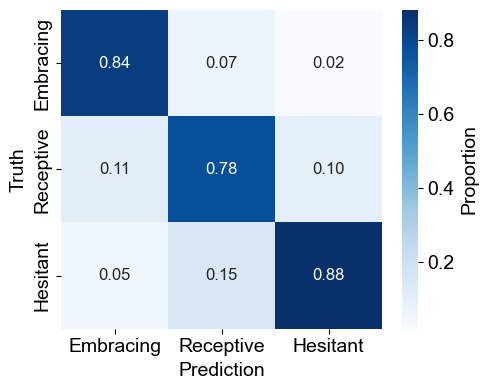

In [358]:
# 混淆矩阵
print("\nPlotting a confusion matrix...")
cm = confusion_matrix(y, y_pred_cv)

cm1 = cm / sum(cm)
print(cm1)

# 可视化混淆矩阵
plt.figure(figsize=(5, 4))
plt.rc('font', family='Arial', weight='normal')

# 创建热图并获取colorbar对象
heatmap = sns.heatmap(
    cm1, 
    annot=True, 
    fmt='.2f', 
    cmap='Blues',
    annot_kws={'size': 12},  # 设置图块标记字体大小为12
    cbar_kws={'label': 'accuracy'},  # 设置colorbar标签为accuracy
    xticklabels=['Embracing', 'Receptive', 'Hesitant'],
    yticklabels=['Embracing', 'Receptive', 'Hesitant']
)

# 设置colorbar字体为12
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel('Proportion', fontsize=14)  # 设置colorbar标签字体大小

# 设置坐标轴标签和刻度
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Prediction', fontsize=14)  # 添加x轴标签
plt.ylabel('Truth', fontsize=14)

plt.tight_layout()
# plt.savefig( r'CM_xgboost.png', dpi=300,transparent=True,bbox_inches = 'tight')
plt.show()